## Klimaexpositionsindex (KEI)

*Voraussetzung:* Alle Teilindizes WEI, HEI, SI, DMI sind robuste z-Werte und so gerichtet, dass **größer = mehr Exposition**.

Sei $x^+ := \max(0, x)$ (verhindert Kompensation einer Gefahr durch unterdurchschnittliche Werte).

Man bemerkt corr(WEI, SI) = -0.75 (siehe unten). Daher treten die Extrema selten gemeinsam auf. 

1) **Starkwind+Starkregen**
$$
S_{\mathrm{WS}} \;=\; \left(\,0.5\cdot(\mathrm{WEI}^+)^p \;+\; 0.5\cdot(\mathrm{SI}^+)^p\,\right)^{1/p}
$$

2) **Gesamtindex**
$$
\mathrm{KEI} \;=\; 0.4\cdot S_{\mathrm{WS}} \;+ \;0.35\cdot \mathrm{HEI}^+ \;+\; 0.25\cdot\mathrm{DMI}^+ 
$$

*Optional für Darstellung:* Danach auf $0$–$100$ skalieren; **nicht** für weitere Rechnungen verwenden.


In [105]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm

# automatischer Reload nach Änderung des geladenen Files
%load_ext autoreload
%autoreload 2
import choropleth_pipeline as cp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Statistische Auswertung Zusammenhang Wind- und Hitze-Expositions-Index

In [204]:
wind = pd.read_csv('csv/WindExposureIndex_2023.csv',dtype={"ARS": "string"}, )
heat = pd.read_csv('csv/HitzeExpositionsIndex_2023.csv',dtype={"ARS": "string"}, )
dmi  = pd.read_csv('csv/DMI_Index.csv',dtype={"ARS": "string"}, )
rain = pd.read_csv('csv/Starkregenindex.csv',dtype={"ARS": "string"}, )

In [205]:
print('WIND: ',wind.columns)
print('HEAT: ',heat.columns)
print('DMI : ',dmi.columns)
print('RAIN: ',rain.columns)

WIND:  Index(['ARS', 'si10_ms_2023', 'si10_ms_2022', 'si10_ms_2021', 'si10_mean',
       'si10_mean_z', 'Index_0_100'],
      dtype='object')
HEAT:  Index(['ARS', 'H30_mean', 'H32_mean', 'H35_mean', 'I30_mean', 'H30_mean_z',
       'H32_mean_z', 'H35_mean_z', 'I30_mean_z', 'Index_raw', 'Index_0_100',
       'HEI_driver', 'I30_std', 'H32_std', 'H35_std', 'I30_cv', 'H32_cv',
       'H35_cv'],
      dtype='object')
DMI :  Index(['ARS', 'dmi_2021_mean', 'dmi_2022_mean', 'dmi_2023_mean', '3ymean_23',
       '3ymean_23_z', '3ymean_0_100'],
      dtype='object')
RAIN:  Index(['ARS', 'RN60_T10_mean', 'HN24_T20_mean', 'RN60_z', 'HN24_z',
       'S_starkregen', 'S_starkregen_0_100', 'RN60_0_100', 'HN24_0_100'],
      dtype='object')


In [206]:
df = wind.merge(heat, on = 'ARS', how = 'inner').merge(dmi, on = 'ARS', how = 'inner').merge(rain, on = 'ARS', how = 'inner').copy()

In [207]:
print('cols: ', df.columns)
print('shape:', df.shape)

cols:  Index(['ARS', 'si10_ms_2023', 'si10_ms_2022', 'si10_ms_2021', 'si10_mean',
       'si10_mean_z', 'Index_0_100_x', 'H30_mean', 'H32_mean', 'H35_mean',
       'I30_mean', 'H30_mean_z', 'H32_mean_z', 'H35_mean_z', 'I30_mean_z',
       'Index_raw', 'Index_0_100_y', 'HEI_driver', 'I30_std', 'H32_std',
       'H35_std', 'I30_cv', 'H32_cv', 'H35_cv', 'dmi_2021_mean',
       'dmi_2022_mean', 'dmi_2023_mean', '3ymean_23', '3ymean_23_z',
       '3ymean_0_100', 'RN60_T10_mean', 'HN24_T20_mean', 'RN60_z', 'HN24_z',
       'S_starkregen', 'S_starkregen_0_100', 'RN60_0_100', 'HN24_0_100'],
      dtype='object')
shape: (10957, 38)


### Korrelation zwischen Features
$|\rho|<0.5$ ist ein guter Ansatz. Es bedeutet Features sind unabhängig genug

In [208]:
cdf = df[['ARS','si10_mean_z','Index_raw','3ymean_23_z','S_starkregen']].copy()
cdf.rename(columns = {'si10_mean_z':'WEI','Index_raw':'HEI','3ymean_23_z':'DMI','S_starkregen':'SI'}, inplace = True)
cdf.columns

Index(['ARS', 'WEI', 'HEI', 'DMI', 'SI'], dtype='object')

In [209]:
cdf[['WEI', 'HEI', 'DMI', 'SI']].corr()

WEI       HEI       DMI        SI
WEI  1.000000 -0.289681 -0.279155 -0.752616
HEI -0.289681  1.000000 -0.478618  0.012998
DMI -0.279155 -0.478618  1.000000  0.479750
SI  -0.752616  0.012998  0.479750  1.000000

### Transform Data and Compute KEI

In [210]:
# die geladenen Daten sind bereits z-normiert (robust)
cdf['DMI'] = np.maximum( -cdf['DMI'],0)
cdf['WEI'] = np.maximum(  cdf['WEI'],0)
cdf['HEI'] = np.maximum(  cdf['HEI'],0)
cdf['SI']  = np.maximum(  cdf['SI'] ,0)

p= 6.0
cdf['SWS'] = (0.5* cdf['WEI']**p + 0.5* cdf['SI']**p)**(1/p)


In [211]:
cdf['KEI'] = 0.4 * cdf['SWS'] + 0.35 * cdf['HEI'] + 0.25 * cdf['DMI']

In [212]:
cdf.columns

Index(['ARS', 'WEI', 'HEI', 'DMI', 'SI', 'SWS', 'KEI'], dtype='object')

In [213]:
# cdf.to_csv('csv/KlimaIndex.csv', index = False)

### Rescale and plot

In [214]:
# Geometrie laden und geodataframe erstellen
VG250_GPKG = "../geometry/DE_VG250.gpkg" 
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")
gemeinden = cp.load_level(vg, 'GEM')
kreise    = cp.load_level(vg, 'KRS')
laender   = cp.load_level(vg, 'LAN')

In [215]:
gdf = gemeinden.merge(cdf, on = 'ARS', how = 'inner')

gdf['KEI_0_100'] = cp.scale_0_100(gdf['KEI'])

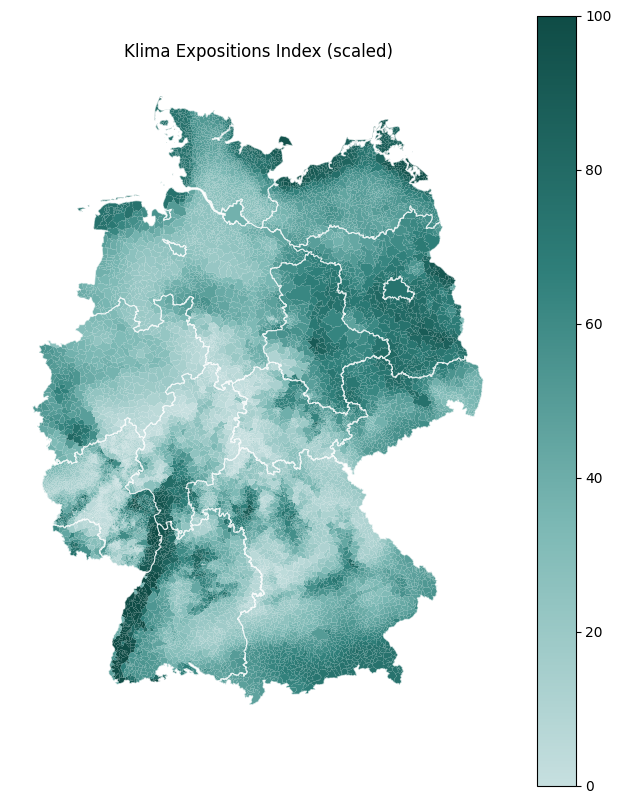

In [14]:
value_col = "KEI_0_100"

from matplotlib.colors import LinearSegmentedColormap
kei_tealnavy = LinearSegmentedColormap.from_list(
    "kei_tealnavy",
    ["#c6dfdf", "#7db9b5", "#2f7f7a", "#0f4c46"],  # Q1 → Q4 Stops
    N=256
)

fig, ax = cp.plot_choropleth_continuous(
    gdf,
    value_col,
    cmap_name = kei_tealnavy,          
    title=f"Klima Expositions Index (scaled)",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100) 
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"KEI_scaled.png", 
    out_dir="exports",
    dpi=300
)

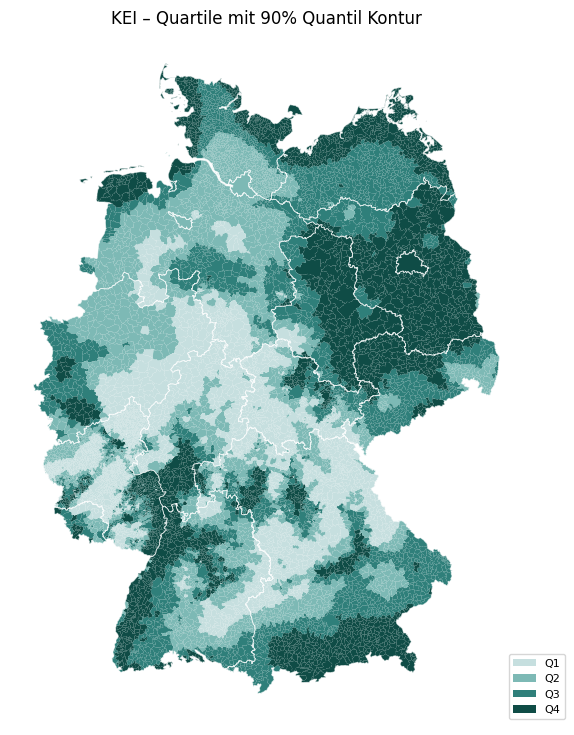

In [16]:
col = "KEI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = ["#c6dfdf", "#7db9b5", "#2f7f7a", "#0f4c46"]

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="KEI – Quartile mit 90% Quantil Kontur",
    # legend_offset_cm=1.0
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"KEI_scaled_quartiles.png", 
    out_dir="exports",
    dpi=300
)

### Mit q90 Kontur

In [15]:
col = "KEI_0_100"  

# 90% Quantil-Schwelle berechnen
q90 = gdf[col].quantile(0.9)
gdf_hot = gdf[gdf[col] > q90].copy().dissolve()

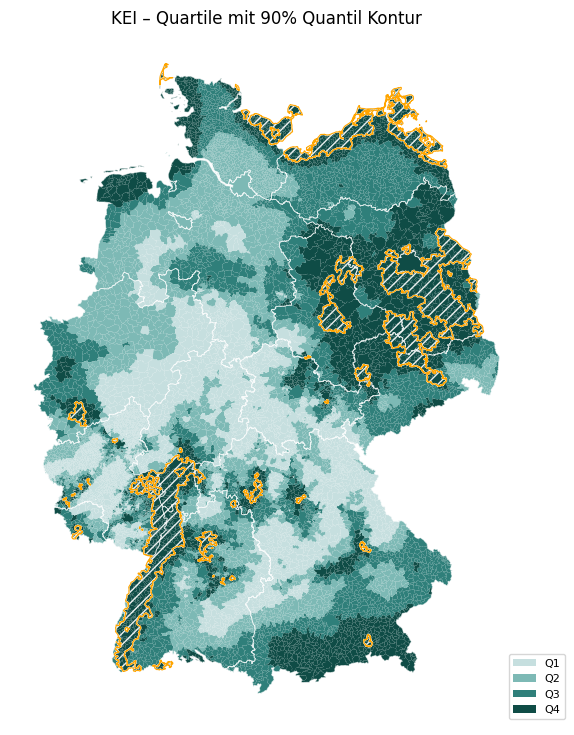

In [17]:
# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = ["#c6dfdf", "#7db9b5", "#2f7f7a", "#0f4c46"]

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="KEI – Quartile mit 90% Quantil Kontur",
    # legend_offset_cm=1.0
)
gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'orange',
    linewidth = 0.8,
)
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"KEI_scaled_quartiles_boundaryq90.png", 
    out_dir="exports",
    dpi=300
)


### Zoom into Hotspots

# Osten

In [115]:
# Punkte festlegen für die großen Städte in der Region
pk = cp.load_level(vg, 'PK')

select_cities = [
    'Berlin',
    'Cottbus',
    'Dresden',
    'Leipzig',
    'Chemnitz',
    'Magdeburg',
    'Halle (Saale)'
    'Dessau-Roßlau',
    'Erfurt',
    'Jena',
]

gdf_cities = pk[pk['GEN'].isin(select_cities)].copy() 

['12', '11', '14', '15', '16']


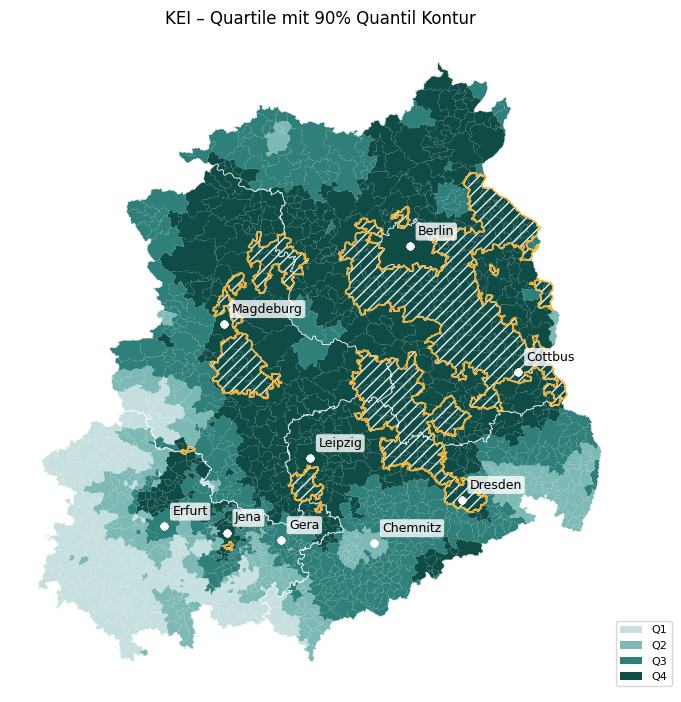

In [116]:
# Auswahl
zoom = ['BB','BE','SN','SA','TH']
states = []

# String für Dateibezeichner
reg_str = ""
for region in zoom:
    reg_str = reg_str + "_" + region
    states.append(cp.KUERZEL[region])

print(states)

gdf_zoom = gdf[gdf['ARS'].str[:2].isin(states)].copy()
laender_zoom = laender[laender['ARS'].str[:2].isin(states)].copy()


q90 = gdf[col].quantile(0.9)
gdf_hot = gdf_zoom[gdf_zoom[col] > q90].dissolve()

# spalte wählen
col = "KEI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = ["#c6dfdf", "#7db9b5", "#2f7f7a", "#0f4c46"]

fig, ax = cp.plot_choropleth_discrete(
    gdf_zoom, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender_zoom,
    states = states,
    title="KEI – Quartile mit 90% Quantil Kontur",
    # legend_offset_cm=1.0
)

# globales q90 überlagern
gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)

gdf_hot.boundary.plot(
    ax = ax,
    color = 'orange',
    linewidth = 0.8,
)

# städteposition mit label plotten
cp.plot_pk(ax, gdf_cities, name_col="GEN", dx=6, dy=6, color = 'white')

In [117]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"KEI_{reg_str}.png", 
    out_dir="exports",
    dpi=300
)

# Oberrheingraben

In [169]:
# Punkte festlegen für die großen Städte in der Region
pk = cp.load_level(vg, 'PK')

select_cities = [
    'Kaiserslautern',
    'Frankfurt am Main',
    'Koblenz',
    'Trier',
    'Kassel',
    'Würzburg',
    'Regensburg',
    'Rosenheim',
    'Erlangen',
    'Marbach',
]

gdf_cities = pk[pk['GEN'].isin(select_cities)].copy() 

['08', '07', '06', '09']


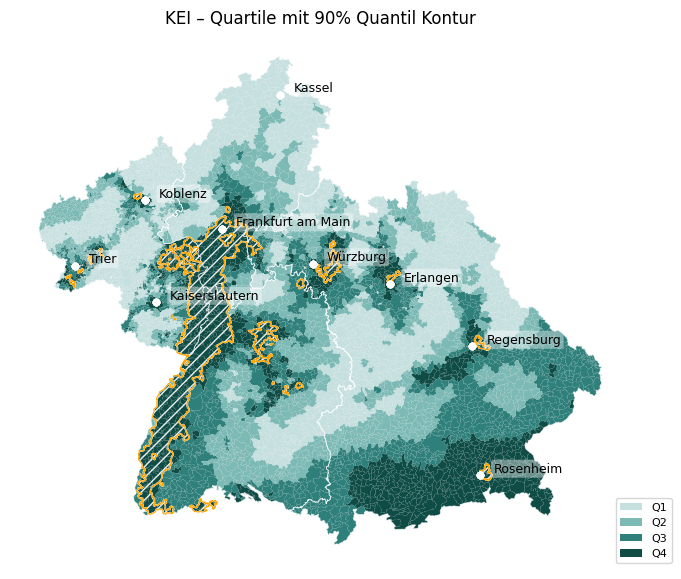

In [170]:
# Auswahl
zoom = ['BW','RP','HE','BY']
states = []

# String für Dateibezeichner
reg_str = ""
for region in zoom:
    reg_str = reg_str + "_" + region
    states.append(cp.KUERZEL[region])

print(states)

gdf_zoom = gdf[gdf['ARS'].str[:2].isin(states)].copy()
laender_zoom = laender[laender['ARS'].str[:2].isin(states)].copy()


q90 = gdf[col].quantile(0.9)
gdf_hot = gdf_zoom[gdf_zoom[col] > q90].dissolve()

# spalte wählen
col = "KEI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = ["#c6dfdf", "#7db9b5", "#2f7f7a", "#0f4c46"]

fig, ax = cp.plot_choropleth_discrete(
    gdf_zoom, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender_zoom,
    states = states,
    title="KEI – Quartile mit 90% Quantil Kontur",
    # legend_offset_cm=1.0
)

gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'orange',
    linewidth = 0.8,
)

# städteposition mit label plotten
cp.plot_pk(ax, gdf_cities, name_col="GEN", dx=10, dy=0, color = 'white')

In [171]:

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"KEI_{reg_str}.png", 
    out_dir="exports",
    dpi=300
)

### Küste

In [121]:
# Punkte festlegen für die großen Städte in der Region
pk = cp.load_level(vg, 'PK')

select_cities = [
    'Schwerin',
    'Rostock',
    'Kiel',
    'Lübeck',
    # 'Flensburg',
    # 'Neumünster',
]

gdf_cities = pk[pk['GEN'].isin(select_cities)].copy() 

['13', '01']


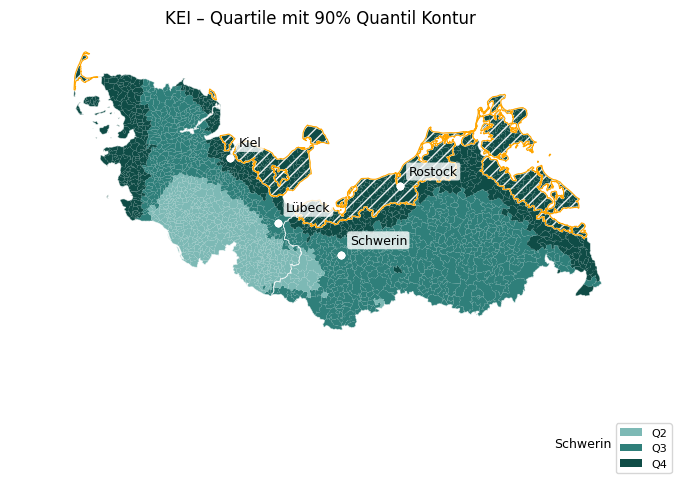

In [122]:
# Auswahl
zoom = ['MV','SH']
states = []

# String für Dateibezeichner
reg_str = ""
for region in zoom:
    reg_str = reg_str + "_" + region
    states.append(cp.KUERZEL[region])

print(states)

gdf_zoom = gdf[gdf['ARS'].str[:2].isin(states)].copy()
laender_zoom = laender[laender['ARS'].str[:2].isin(states)].copy()


q90 = gdf[col].quantile(0.9)
gdf_hot = gdf_zoom[gdf_zoom[col] > q90].dissolve()

# spalte wählen
col = "KEI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = ["#c6dfdf", "#7db9b5", "#2f7f7a", "#0f4c46"]

fig, ax = cp.plot_choropleth_discrete(
    gdf_zoom, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender_zoom,
    states = states,
    title="KEI – Quartile mit 90% Quantil Kontur",
    # legend_offset_cm=1.0
)

gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'orange',
    linewidth = 0.8,
)

# städteposition mit label plotten
cp.plot_pk(ax, gdf_cities, name_col="GEN", dx=6, dy=6, color = 'white')


In [123]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"KEI_{reg_str}.png", 
    out_dir="exports",
    dpi=300
)

# Bayern

['09']


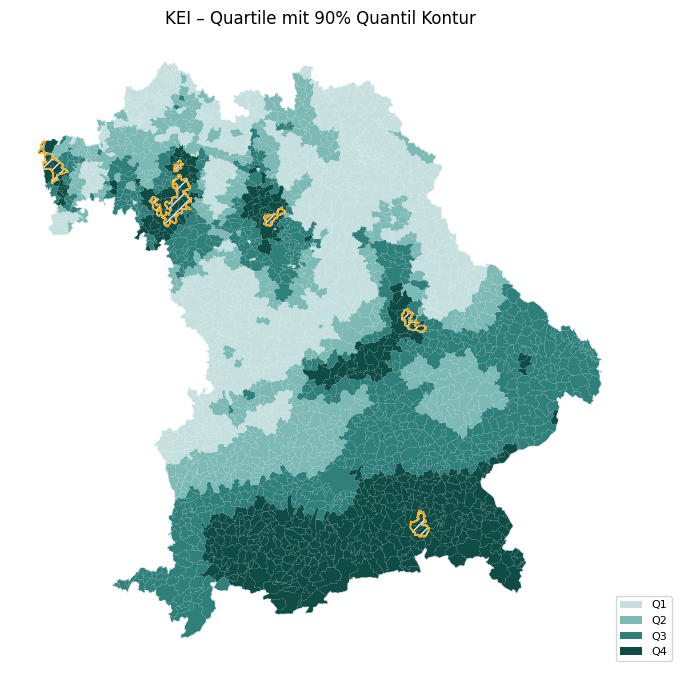

In [21]:
# Auswahl
zoom = ['BY']
states = []

# String für Dateibezeichner
reg_str = ""
for region in zoom:
    reg_str = reg_str + "_" + region
    states.append(cp.KUERZEL[region])

print(states)

gdf_zoom = gdf[gdf['ARS'].str[:2].isin(states)].copy()
laender_zoom = laender[laender['ARS'].str[:2].isin(states)].copy()


q90 = gdf[col].quantile(0.9)
gdf_hot = gdf_zoom[gdf_zoom[col] > q90].dissolve()

# spalte wählen
col = "KEI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = ["#c6dfdf", "#7db9b5", "#2f7f7a", "#0f4c46"]

fig, ax = cp.plot_choropleth_discrete(
    gdf_zoom, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender_zoom,
    states = states,
    title="KEI – Quartile mit 90% Quantil Kontur",
    # legend_offset_cm=1.0
)

gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'orange',
    linewidth = 0.8,
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"KEI_{reg_str}.png", 
    out_dir="exports",
    dpi=300
)

## KEI Komponenten - Quartilplots

In [22]:
gdf.columns

Index(['OBJID', 'BEGINN', 'ADE', 'GF', 'BSG', 'ARS', 'AGS', 'SDV_ARS', 'GEN',
       'BEZ', 'IBZ', 'BEM', 'NBD', 'SN_L', 'SN_R', 'SN_K', 'SN_V1', 'SN_V2',
       'SN_G', 'FK_S3', 'NUTS', 'ARS_0', 'AGS_0', 'WSK', 'DLM_ID', 'geometry',
       'WEI', 'HEI', 'DMI', 'SI', 'SWS', 'KEI', 'KEI_0_100'],
      dtype='object')

In [23]:
gdf['SWS_0_100'] = cp.scale_0_100(gdf['SWS'],1,99)
gdf['SI_0_100'] = cp.scale_0_100(gdf['SI'],1,99)
gdf['WEI_0_100'] = cp.scale_0_100(gdf['WEI'],1,99)
gdf['DMI_0_100'] = cp.scale_0_100(gdf['DMI'],1,99)
gdf['HEI_0_100'] = cp.scale_0_100(gdf['HEI'],1,99)



gdf1 = gemeinden.merge(cdf, on = 'ARS', how = 'inner')

gdf1['KEI_0_100'] = cp.scale_0_100(gdf1['KEI'])


In [24]:
# Farbschemen für quantil-plots
SCHEMES = {
    # Wind (Blau) 
    "WEI": ["#c6dbef", "#9ecae1", "#6baed6", "#2171b5"],
    # Starkregen (Türkis)
    "SI":  ["#b9dede", "#78c6c8", "#3a86a8", "#005f73"],
    # S_WS (Blau→Teal) 
    "SWS": ["#cde3ee", "#86b9d6", "#4f93c5", "#205f90"],
    # Hitze (Orange) 
    "HEI": ["#fed9a6", "#fdb977", "#fd8d3c", "#a63603"],
    # Dürre = −DMI (Orange-Rot) 
    "DMI": ["#fee8c8", "#fdbb84", "#fc8d59", "#d7301f"],
}

### Pluvial / Aeolisch

In [25]:

col = "SWS_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, 0.5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = SCHEMES['SWS']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="SWS – Quartile",
    # legend_offset_cm=1.0
)

#--------------------------------------------------------------------------
# overlay q10 KEI Kontur
# 90% Quantil-Schwelle berechnen
q90 = gdf1['KEI_0_100'].quantile(0.9)
gdf_hot = gdf1[gdf1['KEI_0_100'] > q90].copy().dissolve()

gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'black',
    linewidth = 0.8,
)
# ---------------------------------------------------------------------------

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"SWS_Quartile_mit_overlay.png", 
    out_dir="exports",
    dpi=300
)

In [216]:
# Auswahl
zoom = ['BB', 'BE', 'TH', 'SA', 'SN']

states_str = ''

for state in zoom:
    states_str +=  "_"+state

print(states_str)
states = []

# String für Dateibezeichner
reg_str = ""
for region in zoom:
    reg_str = reg_str + "_" + region
    states.append(cp.KUERZEL[region])

gdf_zoom = gdf[gdf['ARS'].str[:2].isin(states)].copy()
laender_zoom = laender[laender['ARS'].str[:2].isin(states)].copy()


q90 = gdf['KEI'].quantile(0.9)
gdf_hot = gdf_zoom[gdf_zoom['KEI'] > q90].dissolve()


# spalte wählen
col = "DMI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = SCHEMES[col[:3]]

fig, ax = cp.plot_choropleth_discrete(
    gdf_zoom, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender_zoom,
    states = states,
    title=f"{col} – Quartile mit 90% Quantil Kontur",
    # legend_offset_cm=1.0
)

gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'orange',
    linewidth = 0.8,
)


_BB_BE_TH_SA_SN


KeyError: 'DMI_0_100'

In [198]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"{col}_Quartile_mit_overlay{states_str}.png", 
    out_dir="exports",
    dpi=300
)

### Starkregenindex

In [26]:
col = "SI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, 0.5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = SCHEMES['SI']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="SI (Starkregen) – Quartile",
    # legend_offset_cm=1.0
)



# # Speichern
out_file = cp.save_map(
    fig, 
    filename=f"SI_Starkregen_Quartile.png", 
    out_dir="exports",
    dpi=300
)

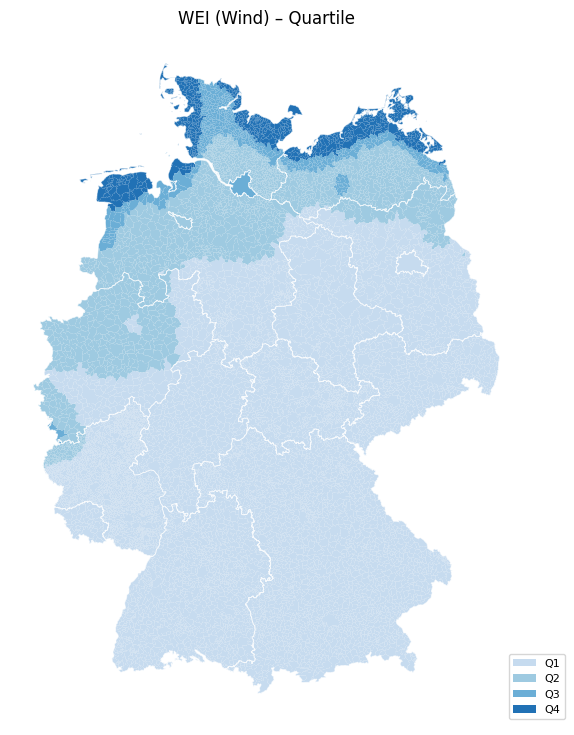

In [27]:
col = "WEI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, 0.5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = SCHEMES['WEI']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="WEI (Wind) – Quartile",
    # legend_offset_cm=1.0
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"WEI_Wind_Quartile.png", 
    out_dir="exports",
    dpi=300
)

### Hitze

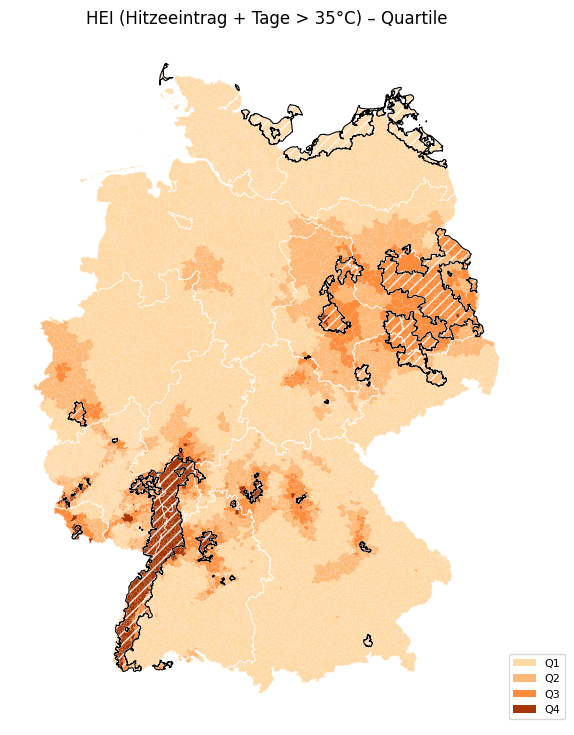

In [28]:
col = "HEI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, 0.5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = SCHEMES['HEI']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="HEI (Hitzeeintrag + Tage > 35°C) – Quartile",
    # legend_offset_cm=1.0
)

#--------------------------------------------------------------------------
# overlay q10 KEI Kontur
# 90% Quantil-Schwelle berechnen
q90 = gdf1['KEI_0_100'].quantile(0.9)
gdf_hot = gdf1[gdf1['KEI_0_100'] > q90].copy().dissolve()

gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'black',
    linewidth = 0.8,
)
# ---------------------------------------------------------------------------

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"HEI_Hitze_Quartile_with_overlay.png", 
    out_dir="exports",
    dpi=300
)

### Dürre nach de Martonne

In [29]:
col = "DMI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, 0.5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = SCHEMES['DMI']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="de Martonne Dürre index (-DMI) – Quartile",
    # legend_offset_cm=1.0
)

#--------------------------------------------------------------------------
# overlay q10 KEI Kontur
# 90% Quantil-Schwelle berechnen
q90 = gdf1['KEI_0_100'].quantile(0.9)
gdf_hot = gdf1[gdf1['KEI_0_100'] > q90].copy().dissolve()

gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'black',
    linewidth = 0.8,
)
# ---------------------------------------------------------------------------

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"DMI_Dürre_Quartile_with_overlay.png", 
    out_dir="exports",
    dpi=300
)

In [30]:
# Speichern der Fläche
# gdf_hot.to_parquet('csv/q90.parquet', index = False)

### Ahrtal

In [31]:
kreise  = cp.load_level(vg, 'KRS')
laender = cp.load_level(vg, 'LAN')

In [85]:
ahrtal = kreise[
    (kreise['GEN'] == 'Ahrweiler') |
    (kreise['GEN'] == 'Euskirchen') |
    (kreise['GEN'] == 'Vulkaneifel') 
    ].copy().dissolve()

# Schuld an der Ahr
schuld_city = gpd.GeoDataFrame(
    {"name":["Schuld (Ahr)"]},
    geometry=gpd.points_from_xy([6.88944],[50.44583]),
    crs="EPSG:4326"
).to_crs(kreise.crs)

In [86]:
schuld_city

name                        geometry
0  Schuld (Ahr)  POINT (350152.076 5590330.429)

In [94]:
# Auswahl
zoom = ['NW','RP']
states = []

# String für Dateibezeichner
reg_str = ""
for region in zoom:
    reg_str = reg_str + "_" + region
    states.append(cp.KUERZEL[region])

print(states)

gdf_zoom = gdf[gdf['ARS'].str[:2].isin(states)].copy()
laender_zoom = laender[laender['ARS'].str[:2].isin(states)].copy()


q90 = gdf[col].quantile(0.9)
gdf_hot = gdf_zoom[gdf_zoom[col] > q90].dissolve()

# spalte wählen
col = "KEI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = ["#c6dfdf", "#7db9b5", "#2f7f7a", "#0f4c46"]

fig, ax = cp.plot_choropleth_discrete(
    gdf_zoom, col,
    bins=bins, labels=labels, colors=colors,
    # laender=laender_zoom,
    # states = states,
    title="KEI – Quartile mit 90% Quantil Kontur",
    # legend_offset_cm=1.0
)

gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '///',
    linewidth = 1.2,
    alpha = 0.9,
)
ahrtal.boundary.plot(
    ax = ax,
    color = 'black',
    alpha = 0.6,
)

gdf_hot.boundary.plot(
    ax = ax,
    color = 'orange',
    linewidth = 0.8,
)

schuld_city.plot(
    ax=ax,
    marker="o",
    color="black",
    markersize=20,
    zorder=10
)
# nach deinem Plot:
x = schuld_city.geometry.x.iloc[0]
y = schuld_city.geometry.y.iloc[0]

# 6 Punkte nach rechts/oben versetzt, mit heller Box für Lesbarkeit
ax.annotate(
    "Schuld (Ahr)", xy=(x, y),
    xytext=(6, 6), textcoords="offset points",
    fontsize=5, ha="left", va="bottom",
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8),
    zorder=12
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"KEI_{reg_str}.png", 
    out_dir="exports",
    dpi=300
)


['05', '07']


In [95]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"Ahrtal_Quartile_with_overlay.png", 
    out_dir="exports",
    dpi=300
)